# Links

[Open main branch version of this notebook in Colab](https://colab.research.google.com/github/ffvoigt/neuromatch-compneuro-2022-project/blob/main/Adding_Features_to_csv_NM2022_Sfenj1.ipynb)

[Open development branch version of this notebook in Colab](https://colab.research.google.com/github/ffvoigt/neuromatch-compneuro-2022-project/blob/development/Adding_Features_to_csv_NM2022_Sfenj1.ipynb)


# General

The job of this notebook is to:

* Load the processed feature data into a `master_df` DataFrame

* Add handcrafted features 

* Save the `master_df` so it can be used for later classification notebooks

* Feature additions should also be added to the Feature Extraction Notebook

## Style / naming guide / coding hints

* Axes in column labels such as 'X' and 'Y' are always capitalized: e.g. `left_ear_X`
* All coordinates are in cm, area in cm^2
* All angles are in degrees
* 0° is up / north in the video frame
* whenever extracting features, do sanity checks on them:
  * plot time course: are there weird discontinuities etc.?
* often, rounding values makes sense to reduce numerical errors (e.g. angles such as 34.999999° are biologically meaningless -> round to 35°

## Notes regarding the dataset
* mouse 0 is the resident (black) mouse and mouse 1 is the intruder (white) mouse

## ToDo 
* Check order of polygon points for the area calculation

# Housekeeping

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import rc
import matplotlib.patches as mpatches
import seaborn as sns

# Loading the data from Google Drive

In [3]:
#Because we are using a Shared with me drive, we need to have a small workaround
#In your shared with me folder, right click on:
#NMA_2022_Sfenj_Group_1"
#And click "Make a shortcut", and have this shortcut within your own drive

#now we can mount our drive
from pickle import load
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
#Since you have mounted your drive, which includes this shortcut, you can now access the files within that shortcut:
master_df = pd.read_csv('/content/drive/MyDrive/NMA_2022_Sfenj_Group_1/unstable_feature_df.csv', index_col=0)

#test by showing the head
master_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,frame_num,session_num,mouse_id,annotations,nose_X,nose_Y,left_ear_X,left_ear_Y,neck_X,neck_Y,...,acc_head_centroid,acc_body_centroid,acc_centroid,distance,poly_area_head,poly_area_body,int_nose_2_res_tailbase_distance,res_nose_2_int_tailbase_distance,head_coalignment,intertailbase_distance
0,0,0,0,3,22.059926,5.382346,21.370271,6.655555,20.574515,5.037518,...,NaN,NaN,NaN,4.244334,0.378178,1.377622,5.721202,3.287805,111.276780,4.631918
1,1,0,0,1,22.096829,5.355307,21.460224,6.681567,20.637943,5.143105,...,NaN,NaN,NaN,4.257485,0.352497,1.259771,5.813085,3.254851,115.641538,4.732089
2,2,0,0,1,22.247188,4.770894,21.663633,6.495032,20.602625,5.142246,...,147.228931,-96.316187,-6.692275,4.378617,0.557240,1.263289,5.695397,2.676112,138.684873,4.960240
3,3,0,0,1,21.929907,4.645837,21.638130,6.237349,20.550597,4.964140,...,-21.923601,-17.602061,-13.171507,4.361401,0.437631,1.380436,5.561904,2.318348,133.810323,5.284888
4,4,0,0,1,21.804926,4.627531,21.539674,5.900741,20.372565,4.733632,...,16.125266,20.759847,46.678465,4.307015,0.255402,1.513766,5.535471,2.229669,115.397655,5.360140


#### Helper functions

In [4]:
# Function to grab a certain column/feature for a specific mouse id and session:
def grab_feature(featurename, session, mouse_id):
  return master_df.loc[(master_df['session_num']==session) & (master_df['mouse_id']==mouse_id)][featurename]

In [5]:
def plot_feature_vs_frame(feature_label, session_num=0, mouse_id=0):
    feature_series = grab_feature(feature_label, session_num, mouse_id)
    plt.figure(figsize=(10, 6))
    plt.plot(feature_series)

In [6]:
def plot_feature_vs_xy_heatmap(feature_label, session_num=0, mouse_id=0):
  subframe = master_df.loc[(master_df['session_num']==session_num) & (master_df['mouse_id']==mouse_id)]
  x_series = subframe['centroid_body_X']
  y_series = subframe['centroid_body_Y']
  feature_series = subframe[feature_label]

  plt.figure(figsize=(10, 6))
  heatmap = sns.scatterplot(x=x_series, y=y_series, hue=feature_series, palette="magma");
  heatmap.legend(bbox_to_anchor=(1.22, 1), loc='upper right');

#### Add feature here

In [7]:
# Adds a column filled with zeros to the DataFrame
master_df['internose_distance'] = 0
num_sessions = master_df['session_num'].max()

for session in range(0, num_sessions):
  mouse0_x_nose = grab_feature('nose_X', session=session, mouse_id=0)
  mouse0_y_nose = grab_feature('nose_Y', session=session, mouse_id=0)
  mouse1_x_nose = grab_feature('nose_X', session=session, mouse_id=1)
  mouse1_y_nose = grab_feature('nose_Y', session=session, mouse_id=1)

  # Get the indices where the mouse 0 and 1 start and end
  mouse0_start_index = mouse0_x_nose.index[0]
  mouse0_end_index = mouse0_x_nose.index[-1]
  
  mouse1_start_index = mouse1_x_nose.index[0]
  mouse1_end_index = mouse1_x_nose.index[-1]

  # Currently, the dataframes are indexed by frame, we need to drop the indices for further calculation: 
  mouse0_x_nose.reset_index(drop=True, inplace=True)
  mouse0_y_nose.reset_index(drop=True, inplace=True)
  mouse1_x_nose.reset_index(drop=True, inplace=True)
  mouse1_y_nose.reset_index(drop=True, inplace=True)

  # Get the vector pointing from Mouse 0 to 1 and calculate its length
  delta_x = mouse0_x_nose - mouse1_x_nose
  delta_y = mouse0_y_nose - mouse1_y_nose

  distance = np.sqrt(delta_x**2 + delta_y**2)

  # Replace the corresponding values in the master_df for both Mouse 0 and Mouse 1
  # As distance contains an index, .to_numpy() avoids overwriting the first session distances 
  # again and again and filling the rest of the DataFrame with NaNs
  master_df.loc[mouse0_start_index:mouse0_end_index,'internose_distance'] = distance.to_numpy()
  master_df.loc[mouse1_start_index:mouse1_end_index,'internose_distance'] = distance.to_numpy()

## Sanity checking: Plots and heatmaps

In [8]:
def plot_behavior_raster(annotation_sequence, feature_sequence ,start_frame=0,
                         stop_frame=100,
                         title="Behavior Labels"):
  
  # Plot annotations as a behavior raster

  # Map annotations to a number.
  #annotation_num = []
  #for item in annotation_sequence[start_frame:stop_frame]:
  #  annotation_num.append(class_to_number[item])

  # all_classes = list(set(annotation_sequence[start_frame:stop_frame]))

  annotation_sequence = annotation_sequence[start_frame:stop_frame]

  cmap = colors.ListedColormap(['red', 'orange', 'green', 'white'])
  bounds=[-0.5, 0.5, 1.5, 2.5, 3.5]
  norm = colors.BoundaryNorm(bounds, cmap.N)

  height = 600
  arr_to_plot = np.repeat(np.array(annotation_sequence)[:, np.newaxis].transpose(),
                                                  height, axis = 0)
  
  feature_sequence = feature_sequence.to_numpy()

  fig, ax = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [2, 1]})

  #sns.lineplot()
  #axis_id = (0,0)

  ax[0].plot(feature_sequence)
  ax[0].set_xlim([start_frame,stop_frame])
  ax[0].set_xticks([])

  ax[1].imshow(arr_to_plot, interpolation='none',cmap=cmap, norm=norm, aspect='auto')

  ax[1].set_yticks([])
  ax[1].set_xlabel('Frame Number')
  # plt.title(title)

  #legend_patches = []
  #for item in all_classes:
  #  legend_patches.append(mpatches.Patch(color=class_to_color[item], label=item))

  #plt.legend(handles=legend_patches,loc='center left', bbox_to_anchor=(1, 0.5))

  plt.tight_layout()

In [9]:
def plot_feature(feature, session, mouse_id):
  test_annotations = grab_feature('annotations', session=session, mouse_id=mouse_id)
  test_distance = grab_feature(feature, session=session, mouse_id=mouse_id)
  plot_behavior_raster(test_annotations, test_distance, start_frame=0, stop_frame=len(test_annotations))

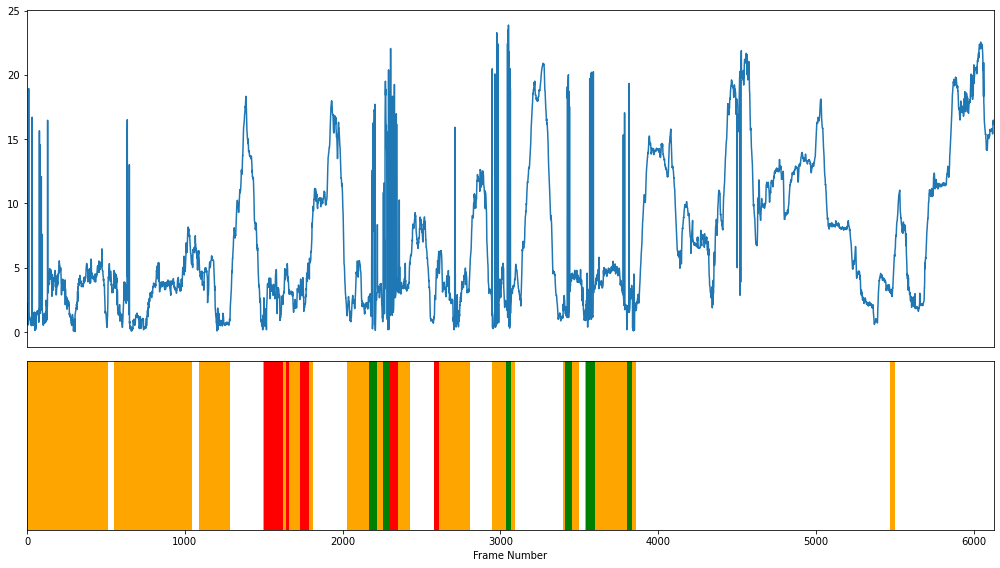

In [12]:
plot_feature('internose_distance', session=17, mouse_id=0)

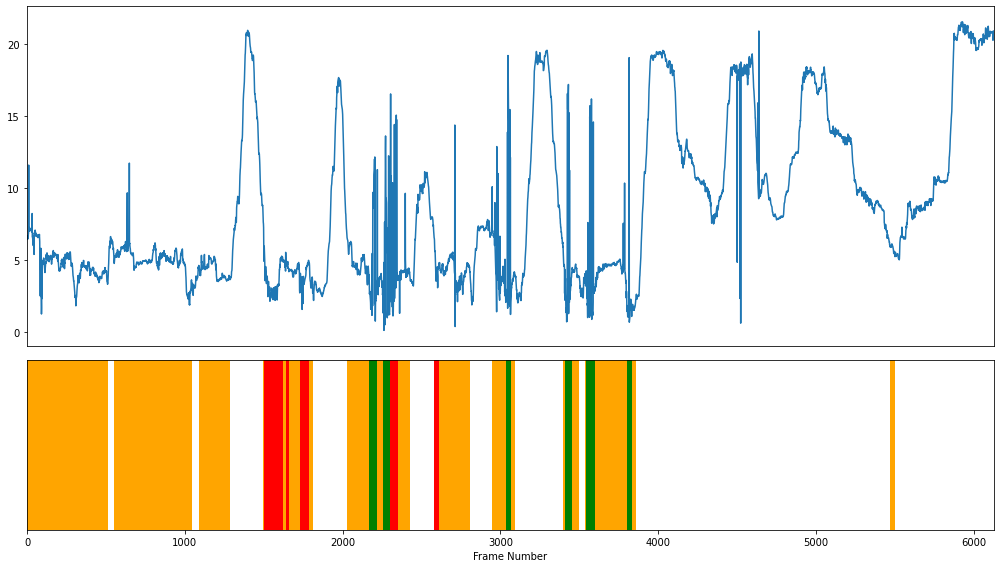

In [13]:
plot_feature('distance', session=17, mouse_id=0)

## Saving new feature frame to .csv

For now, the exported dataframe is unstable as the features are not yet fully checked.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
master_df.to_csv('unstable_feature_df.csv')